Importing all the libraries

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer
import seaborn as sn

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import rand_score
from random import sample
from numpy.random import uniform
from math import isnan
import numpy as np
from sklearn.neighbors import NearestNeighbors as knn

#Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Reading the Excel and create a list of the column names based on the variable type

In [ ]:
#df=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Unsup/Final_Count_Down/Diabetes - UL project 1.xlsx')
df = pd.read_excel("Diabetes - UL project 1.xlsx")

#Dividing the columns
continuous_columns = ['BMI']
categorical_columns = ['Age','Sex','HighChol','CholCheck','Smoker','HeartDiseaseorAttack','PhysActivity','Fruits','Veggies','HvyAlcoholConsump','GenHlth','MentHlth','PhysHlth','DiffWalk']

train_columns = continuous_columns + categorical_columns
target_column = ['Diabetes', 'Hypertension','Stroke']

#Preprocessing

Print the dataset

In [ ]:
df

Check if there are some null values

In [ ]:
df.isna().values.any()

False

Check the type of the features

In [ ]:
print(df.dtypes)

In [ ]:
df.describe()

In [ ]:
df.hist(figsize=(16,16), sharex = True)

Plot of the correlation matrix

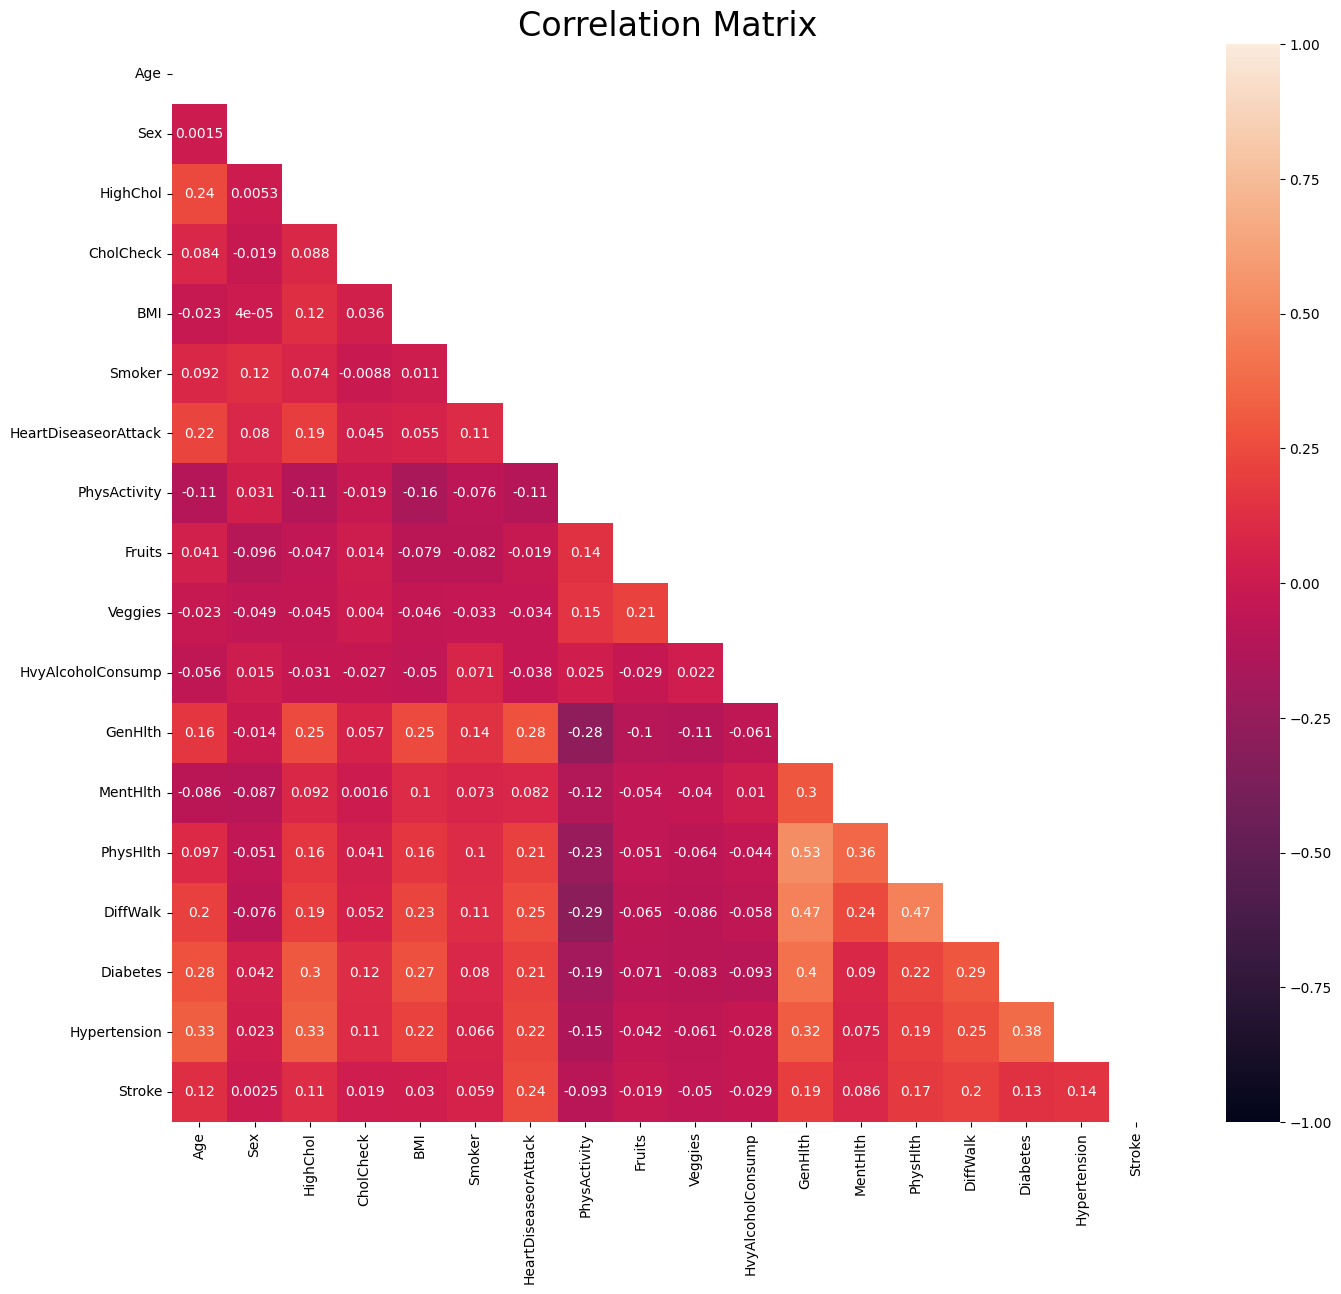

In [ ]:
correlation = df.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
fig, ax = plt.subplots(figsize=(16,14))
sn.heatmap(correlation, mask = mask, ax = ax, vmin=-1, vmax=1, annot=True)
plt.title("Correlation Matrix", fontsize = 24)
plt.show()

Cleaning the Dataset by removing variables without scientific background. More informations are available on the report

In [ ]:
df = df.drop(df[df.BMI > 50].index)

Visual exploration of the dataset

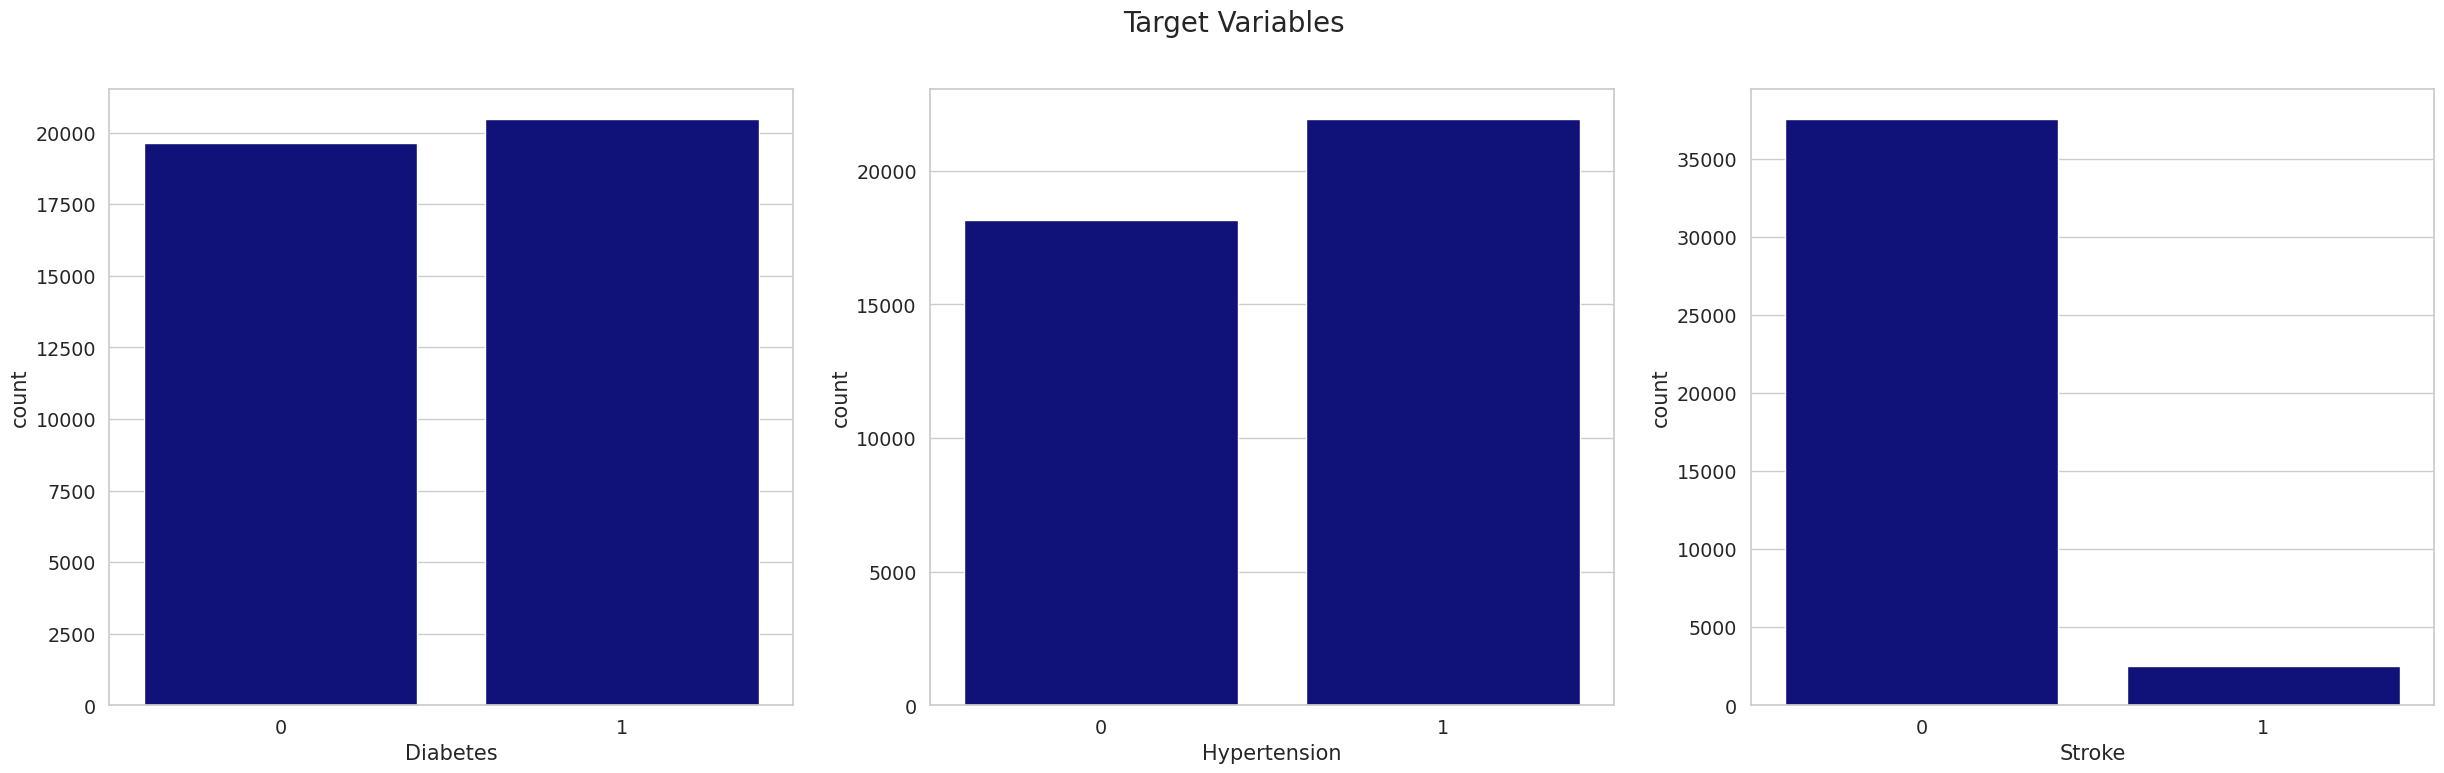

In [ ]:
#plot of the numerical features, takes in input the dataset and the feature we want to plot. In output returns a density distribution plot
def numerical_plot(df, feature):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,9))
    x = df[feature]
    fig = sn.distplot(x = x, ax = ax1, color = "blue")
    fig.set_xlabel("BMI")
    fig.set_ylabel("Density")
    sn.boxplot(data = df, x = feature, ax = ax2, color = 'blue', notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "red"})

numerical_plot(df, "BMI")

#plot of categorical variables, takes in input the dataset. In output returns a histogram with the counts plot
def count_plot(df):
    sn.set(color_codes = 'Blue', style="whitegrid")
    sn.set_style("whitegrid")
    sn.set_context("notebook", font_scale=1.25)

    fig, ax = plt.subplots(1,3, figsize=(30, 8))
    for i in range(3):
      sn.countplot(x=target_column[i], data=df, color = 'darkblue', ax = ax[i])
      #ax[i].set_title(f'{target_column[i]}', fontsize=15)
    fig.suptitle("Target Variables", fontsize=20)
    plt.show()

count_plot(df)

#bivariate plot to compare two variables, requires the two variables and the dataframe. Returns in output the plot of the target variable in function of y
def bivariate_plot(df, x_name, y_name):
    x = df[x_name]
    y = df[y_name]
    ax = sn.scatterplot(x = x,y = y,c='blue', edgecolors='none',alpha=0.5)
    ax.set(xlabel = (x_name), ylabel = (y_name), title = ('{x_name} vs. {y_name}'.format(x_name=x_name, y_name=y_name)))
    plt.show()

bivariate_plot(df, "Diabetes", "Hypertension")

Categorization of the BMI variable

In [ ]:
#Categorizing BMI based on the CDC Classification
df['BMI'] = np.where((df["BMI"] < 18.5), 0 , df["BMI"]) #underweight
df['BMI'] = np.where((df["BMI"] >= 18.5) & (df["BMI"] < 26) , 1 , df["BMI"]) #healthy weight
df['BMI'] = np.where((df["BMI"] >= 25) & (df["BMI"] < 30) , 2 , df["BMI"]) #overweight
df['BMI'] = np.where((df["BMI"] >= 30) & (df["BMI"] < 35) , 3 , df["BMI"]) #Class 1 Obesity
df['BMI'] = np.where((df["BMI"] >= 35) & (df["BMI"] < 40) , 4 , df["BMI"]) #Class 2 Obesity
df['BMI'] = np.where((df["BMI"] >= 40) , 5 , df["BMI"]) #Class 3 Obesity

Saving the True labels

In [ ]:
True_diabetes = df["Diabetes"]
True_stroke = df["Stroke"]
True_hypertension = df["Hypertension"]

df = df.drop(target_column, axis = 1)
matrix_BMI_numerical = df.copy()

### Clusterability

Hopkins Statistics

In [ ]:
#Hopkins Statistic, requires in input the dataframe and outputs a value corresponding to the Hopkins Static
def hopkins(X):
  d = X.shape[1]
  n = len(X) # rows
  m = int(0.1 * n)
  nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

  rand_X = sample(range(0, n, 1), m)

  ujd = []
  wjd = []
  for j in range(0, m):
     u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
     ujd.append(u_dist[0][1])
     w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
     wjd.append(w_dist[0][1])

  H = sum(ujd) / (sum(ujd) + sum(wjd))
  if isnan(H):
     print(ujd, wjd)
     H = 0

  return H

hopkins_score = hopkins(df)
print("Hopkins Score results equal to:", hopkins_score)

Hopkins Score results equal to: 0.7666988160838156


### Outliers Detection

Searching for outliers using K-Nearest Neighbour with two different metrics

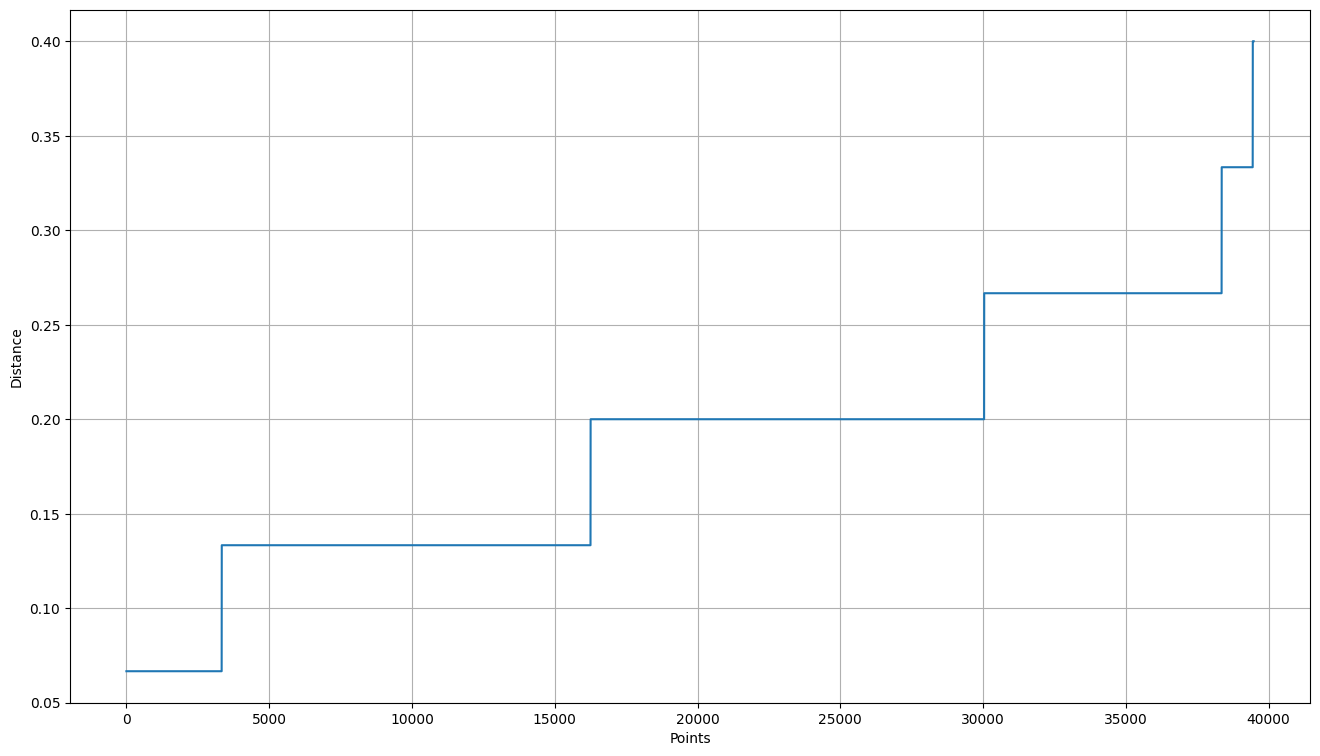

In [ ]:
 #Using K-Nearest Neighbour
neighborhood_order = 150

#First using Hamming Distance function

# Find neighborhood
neighborhood_set   = knn(n_neighbors=neighborhood_order, algorithm='ball_tree', metric= 'hamming').fit(df)
distances, indices = neighborhood_set.kneighbors(df)

# compute distances from 150th nearest neighbors and sort them
dk_sorted     = np.sort(distances[:,-1])
dk_sorted_ind = np.argsort(distances[:,-1])

fig1 = plt.figure(figsize=(16,9))
plt.plot(dk_sorted)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.grid()

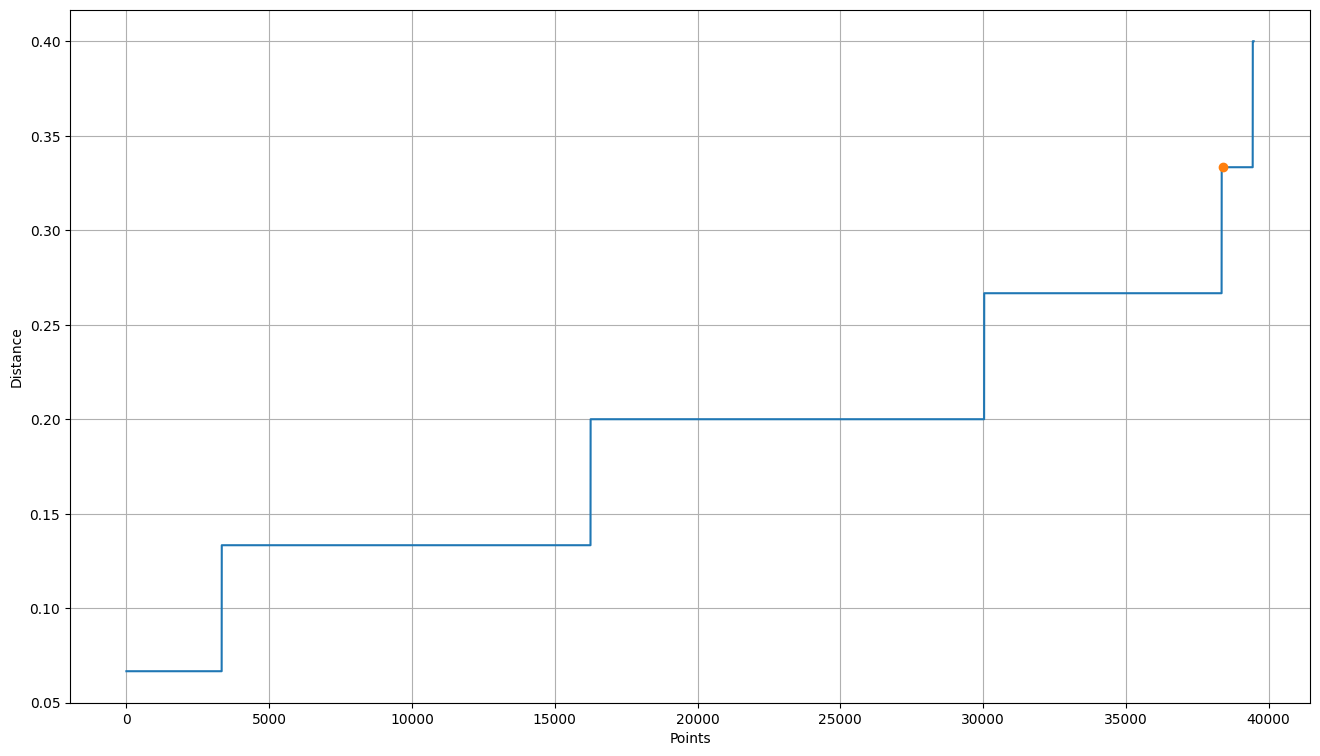

In [ ]:
point = 38400 #identifying the cut point manually and plotting it
fig2 = plt.figure(figsize=(16,9))
plt.plot(dk_sorted)
plt.plot(point, dk_sorted[point],'o')
plt.xlabel("Points")
plt.ylabel("Distance")
plt.grid()

In [ ]:
dk_th = dk_sorted[point] #Lower limit for outliers
id_points2remove = dk_sorted_ind[np.where(dk_sorted>=dk_th)] #identifying the outliers
id_sorted       = np.sort(id_points2remove)
count = len(id_sorted)
print("The number of outliers found is:", count)
NN_labels_hamming = np.ones(df.shape[0])
NN_labels_hamming[id_sorted] = -1          #Assigning label -1 to outliers

The number of outliers found is: 1123


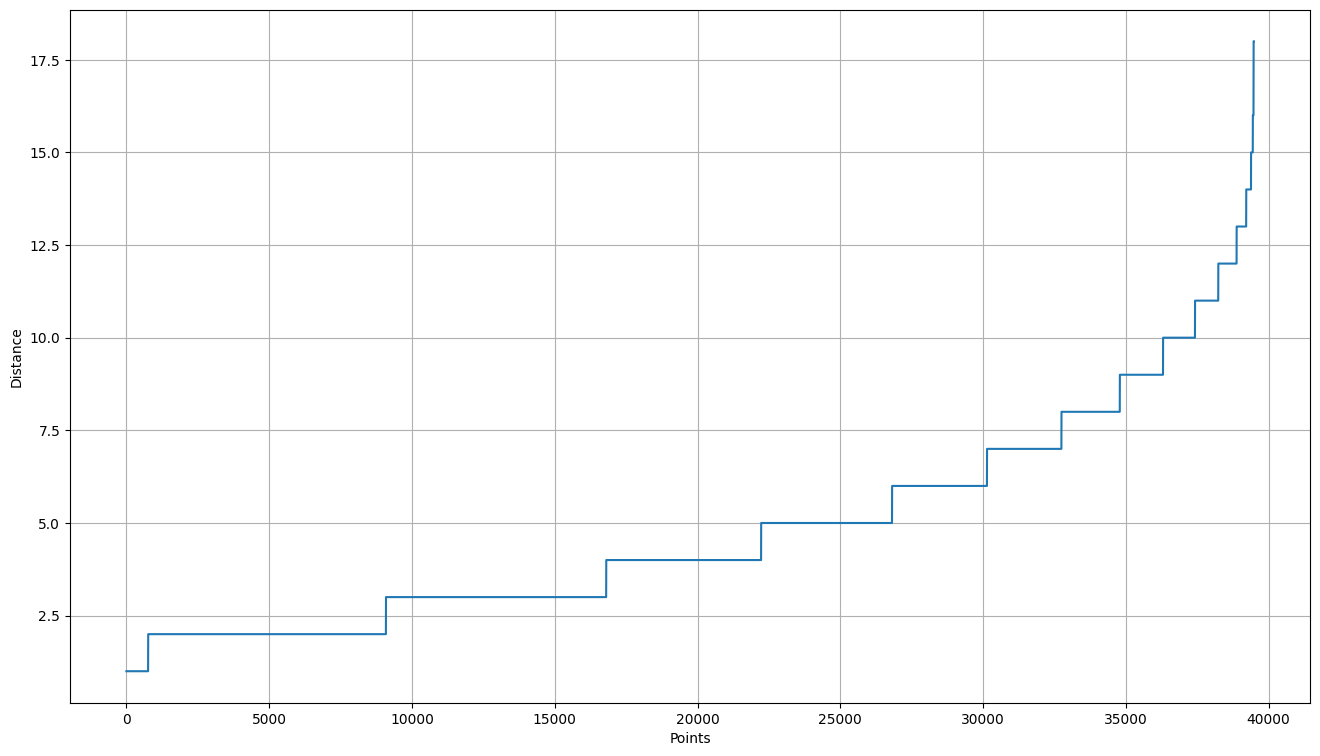

In [ ]:
#Repeating using City Block Metric for a better comparison
neighborhood_order = 150

# Find neighborhood
neighborhood_set   = knn(n_neighbors=neighborhood_order, algorithm='ball_tree', metric= 'cityblock').fit(df)
distances, indices = neighborhood_set.kneighbors(df)

# compute distances from 150th nearest neighbors and sort them
dk_sorted     = np.sort(distances[:,-1])
dk_sorted_ind = np.argsort(distances[:,-1])

fig1 = plt.figure(figsize=(16,9))
plt.plot(dk_sorted)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.grid()

12.0


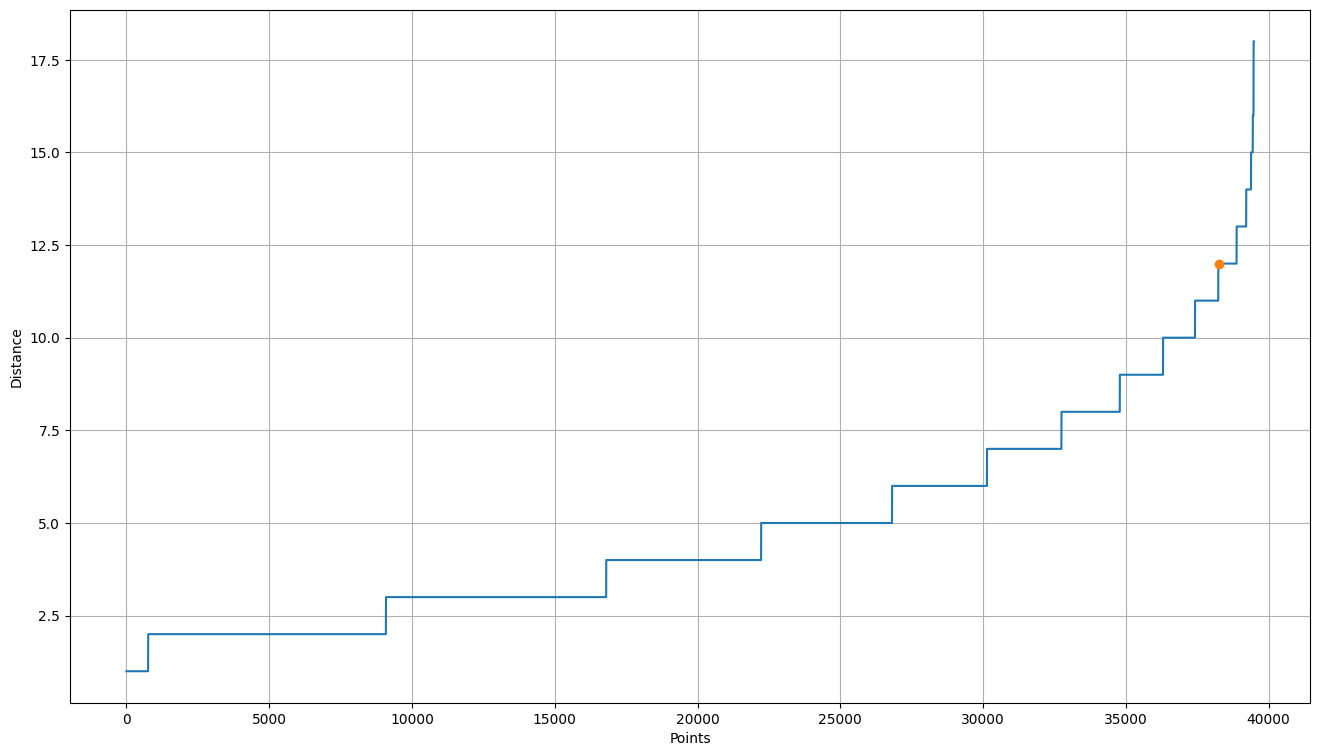

In [ ]:
fig2 = plt.figure(figsize=(16,9))
plt.plot(dk_sorted)
plt.plot(38250, dk_sorted[38250],'o')
print(dk_sorted[38250])
plt.xlabel("Points")
plt.ylabel("Distance")
plt.grid()

In [ ]:
dk_th = dk_sorted[38250] #Lower limit for outliers
id_points2remove = dk_sorted_ind[np.where(dk_sorted>=dk_th)] #identifying the outliers
id_sorted       = np.sort(id_points2remove)
count = len(id_sorted)
print("The number of outliers found is:", count)
NN_labels_cityblock = np.ones(df.shape[0])
NN_labels_cityblock[id_sorted] = -1          #Assigning label -1 to outliers

The number of outliers found is: 1241


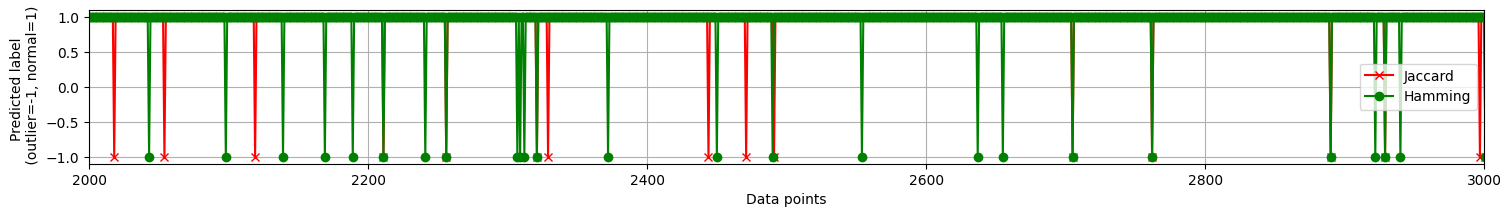

The Rand Score results equal to: 0.921


In [ ]:

y1 = NN_labels_hamming
y2 = NN_labels_cityblock


# Visually inspect the match between the outliers found by City block and Hamming Distance
fig5 = plt.figure('Comparison spotted outliers', figsize=(18,2))
plt.plot(y1, color='red', marker="x", label='Hamming Distance')
plt.plot(y2, color='green', marker="o", label='CityBlock Distance')
plt.xlim(2000,3000)
plt.xlabel('Data points')
plt.ylabel('Predicted label \n (outlier=-1, normal=1)', fontsize=10)
plt.title('Match on outlier detection between Hamming and Cityblock distances')
plt.legend(["Hamming", 'CityBlock'])
plt.grid()
plt.show()

#Computing the Rand Score
rand1 = rand_score(y1, y2)
print("The Rand Score results equal to:", rand1.round(3))


In [ ]:
#Removing the outliers from the DataFrame using cityblock outliers
no_outliers = df.drop(df[y2 == -1].index)

outliers = df[y2 == -1].index

### **Proximity Matrix**

We computed the distance matrix using the Hamming Distance

⛔ **Disclaimer** ⛔

These lines of code must be run on a local machine, otherwise would make Colab crash.

The resulting plot can be found in the report

In [ ]:
from scipy.spatial.distance import pdist

distance_matrix= pdist(df, metric = "hamming") #Using Hamming Distance as distance

from skimage.measure import block_reduce

distance_reduced = block_reduce(distance_matrix, block_size= 1000000) #Applying average pooling to reduce the number of elements

distance_reduced = distance_reduced/1000000 #normalizing distances after pooling

fig1 = plt.figure(figsize = (16,9))
plt.plot(distance_reduced)
plt.title("Proximity Matrix")
plt.ylim(0.42, 0.55)
plt.xlabel("Points")
plt.ylabel("Distance")

#Clustering

Importing all the necessary libraries for the clustering

In [ ]:
pip install kmodes -q

In [ ]:
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from sklearn import metrics
from kmodes.kmodes import KModes
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

## K-Mode

K-Mode algorithm with Huang Initialization

In [ ]:
#First we search for the optimal number of clusters

cost = [] #Elbow method implemented using the Cost function
silhouette_score = [] #Silhouette Score
calinski_harabasz = [] #Calinski Harabasz Score
#for num_clusters in list(range(1,8)): This is used just for the cost function since can be computed also for 1 cluster, otherwise the elbow method wouldn't work
for num_clusters in list(range(2,8)):
    kmode = KModes(n_clusters=num_clusters, init='Huang', random_state=42,n_jobs=-2,max_iter=15,n_init=50) #initializing kmode algorithm
    kmode.fit(no_outliers) #fitting algorithm to the dataframe without outliers
    cluster_labels = kmode.labels_ #saving the labels
    cost.append(kmode.cost_) #comuting the cost
    y = metrics.calinski_harabasz_score(X = no_outliers, labels = cluster_labels) #computing Calinski Harabasz
    x = metrics.silhouette_score(no_outliers, cluster_labels) #Computing Silhouette
    silhouette_score.append(x)
    calinski_harabasz.append(y)

In [ ]:
#Plots used to search the optimal number of clusters
X_bis = list(range(1,8))
X = list(range(2,8))
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18,10))
ax1.plot(X, silhouette_score, linewidth = 3)
ax2.plot(X_bis, cost, linewidth = 3)
ax3.plot(X, calinski_harabasz, linewidth = 3)
ax1.set(xlabel='Number of Clusters', ylabel='Score', title = "Silhouette Score")
ax2.set(xlabel='Number of Clusters', ylabel='Score', title = "Cost function")
ax3.set(xlabel='Number of Clusters', ylabel='Score', title = "Calinski Harabasz Score")

In [ ]:
#Found the best number of clusters to be equal to 2
kmode = KModes(n_clusters=2, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-2) #initializing kmode with 2 clusters
clusters_kmode = kmode.fit_predict(no_outliers)

#Plotting the resulted clustering using only the numerical features and not the categorical ones
no_outliers['Cluster_id_KMode']=clusters_kmode
Diabetes_reduced = no_outliers[["BMI", "PhysHlth", "MentHlth",'Cluster_id_KMode' ]].copy()
sn.pairplot(Diabetes_reduced,hue='Cluster_id_KMode',palette='Dark2',diag_kind='auto', ) #Using the pairplot function of seaborn

##K-Prototype

Implementing the K-prototype algorithm for mixed data

K-Prototype works for mixed data, so in this case we will pass to it the matrix with the mixed data, not the one with BMI categorized

In [ ]:
cost_proto = [] #Elbow method implemented using the Cost function
silhouette_score_proto = [] #Silhouette Score
calinski_harabasz_proto = [] #Calinski Harabasz Score
#for num_clusters in list(range(1,8)):
for num_clusters in list(range(2,8)):
    kprototype = KPrototypes(n_clusters=num_clusters, init='Huang', random_state=42,n_jobs=-2,max_iter=15,n_init=50)
    kprototype.fit(matrix_BMI_numerical)
    cluster_labels_proto = kprototype.labels_
    cost_proto.append(kprototype.cost_)
    y = metrics.calinski_harabasz_score(X = matrix_BMI_numerical, labels = cluster_labels_proto)
    x = metrics.silhouette_score(matrix_BMI_numerical, cluster_labels_proto)
    silhouette_score_proto.append(x)
    calinski_harabasz_proto.append(y)

In [ ]:
X_bis = list(range(1,8))

from kneed import KneeLocator #Finding the knee of the cost functino
i = np.arange(len(X_bis))
knee = KneeLocator(i, cost_proto, S=1, curve='convex', direction='decreasing', interp_method='polynomial')

knee_x = knee.knee
knee_y = cost_proto[knee_x-1] #finding the coordinates of the knee point

<ipython-input-17-0854728ccf24>:6: RankWarning: Polyfit may be poorly conditioned
  knee = KneeLocator(i, asse_y, S=1, curve='convex', direction='decreasing', interp_method='polynomial')


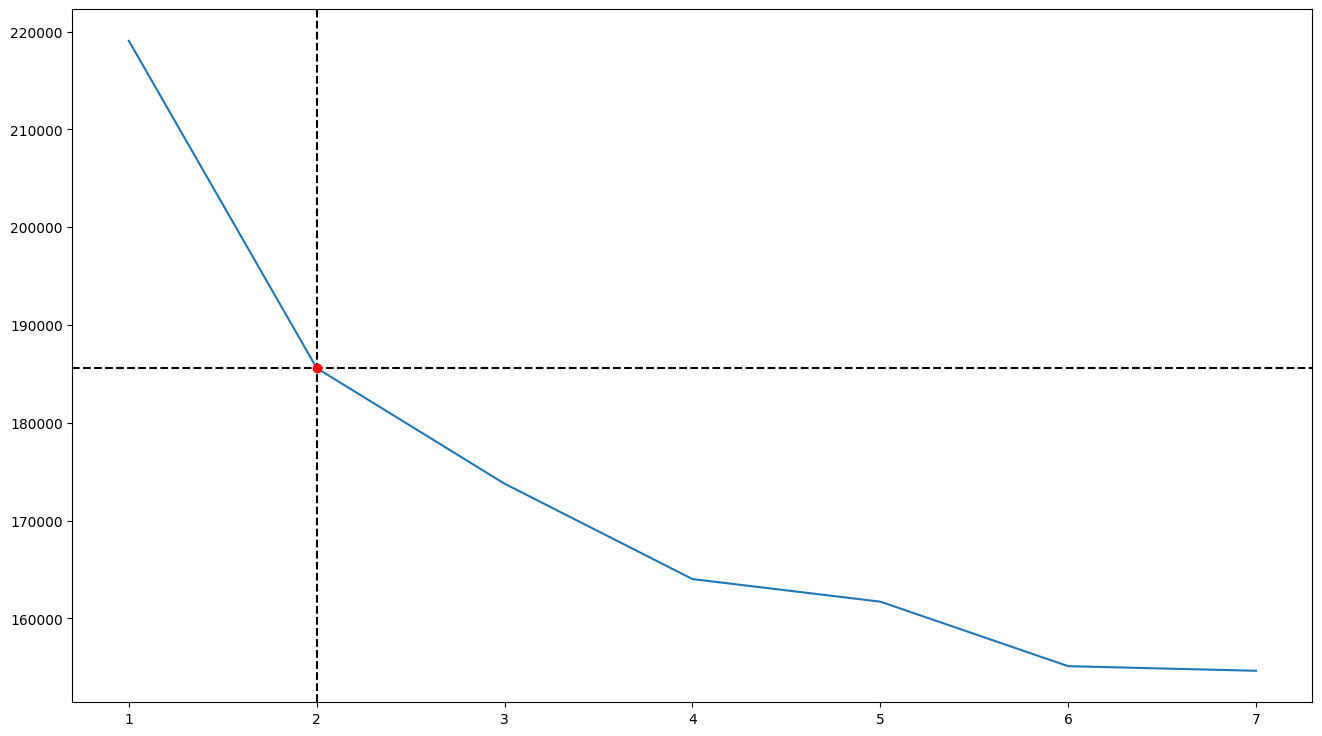

In [ ]:
fig1 = plt.figure(figsize = (16,9))
plt.plot(X_bis, cost_proto)
plt.axvline(x=knee_x, color='k', linestyle='--')
plt.axhline(y=knee_y, color='k', linestyle='--')
plt.plot((knee_x), (knee_y), 'o', color='r')
plt.show()

In [ ]:
#Plots used to search the optimal number of clusters
X_bis = list(range(1,8))
X = list(range(2,8))
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18,10))
ax1.plot(X, silhouette_score, linewidth = 3)
ax2.plot(X_bis, cost, linewidth = 3)
ax2.axvline(x=knee_x, color='k', linestyle='--')
ax2.axhline(y=knee_y, color='k', linestyle='--')
ax2.plot((knee_x), (knee_y), 'o', color='r')
ax3.plot(X, calinski_harabasz, linewidth = 3)
ax1.set(xlabel='Number of Clusters', ylabel='Score', title = "Silhouette Score")
ax2.set(xlabel='Number of Clusters', ylabel='Score', title = "Cost function")
ax3.set(xlabel='Number of Clusters', ylabel='Score', title = "Calinski Harabasz Score")

In [ ]:
#Found the best number of clusters to be equal to 2
kprototype = KPrototypes(n_clusters=2, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-2)
clusters_kproto = kprototype.fit_predict(matrix_BMI_numerical, categorical = [0,1,2,3,5,6,7,8,9,10,11,12,13,14]) #finding cluster labels

#Plotting only some features for estetic reason
matrix_BMI_numerical['Cluster_id_KMode']=clusters_kproto
Diabetes_reduced = matrix_BMI_numerical[["BMI", "PhysHlth", "MentHlth",'Cluster_id_KMode' ]].copy()
sn.pairplot(Diabetes_reduced,hue='Cluster_id_KMode',palette='Dark2',diag_kind='auto', ) #Using the pairplot function of seaborn

## Hierarchical Clustering

In [ ]:
#Computing silhouette and Calinski Harabasz Scores
def calcolo_sil(df, lab, metr):
  if (len(np.unique(lab))==1):
    s=0
  else:
    s= metrics.silhouette_score(df, lab, metric=metr)
  return s

def calcolo_kz(df, lab):
  if (len(np.unique(lab))==1):
    kz=0
  else:
    kz = metrics.calinski_harabasz_score(X = df, labels = lab)
  return kz

Hyperparameter Tuning

In the code, we perform hyperparameter tuning on merging methods, metrics, and different possible numbers of clusters.
To do this, we create all pairs of merging methods and metrics. For each pair, we calculate the maximum value of the dendrogram,
calculate thirty percent of the maximum, and perform n cuts between the maximum and thirty percent less than the maximum.
For each of these heights, we calculate the clusters and evaluate the Silhouette score and Calinski-Harabasz score.
The code returns three three-dimensional arrays containing the two metrics for each combination and the number of clusters found for each combination.

In [ ]:
#number of the cuts
n=10
# methods merging that we use
method_merging_list= ['single', 'average', 'complete', 'weighted']
# metrics that we use
metrics_list=['jaccard', 'hamming', 'cityblock']
#Creating all the possible combos between the methods merging and the metrics
combos = [( (merg, merg_idx), (metr, metr_idx))  for merg_idx, merg in enumerate(method_merging_list) for metr_idx, metr in enumerate(metrics_list)]

#create all the arrays were we will save all the scores
all_silhuette = np.zeros((n,len(method_merging_list),len(metrics_list)))
all_kz = np.zeros((n,len(method_merging_list),len(metrics_list)))
all_num_cluster = np.zeros((n,len(method_merging_list),len(metrics_list)))
#iterating on the combos
for (merg, i_merg), (metr, i_metr) in combos:
  #calculate the linkage
  Z = hierarchy.linkage(no_otliers, merg, metr)
  #calculate the dendrogram
  dn = hierarchy.dendrogram(Z, truncate_mode='level')
  #calculate the maximum value of the dendrogram and the thirty percent of the maximum
  max_val=dn['dcoord']
  max_dendogram=max(max_val[-1])
  trenta_percento=(max_dendogram/100)*30
  #Creating n cuts between the maximum minus thirty percent of the maximum and the maximum value of the dendrogram.
  cluster_numbers=np.linspace(max_dendogram-trenta_percento, max_dendogram, n)
  #Iterations to iterate through all possible cuts in the current combo.
  for n , i_n in zip(cluster_numbers, range(len(cluster_numbers))):
      #Cluster calculation
      labels = fcluster(Z, n, criterion='distance')
      #Saving silhouette score, Calinski-Harabasz score, and the number of clusters created.
      all_silhuette[i_n][i_merg][i_metr] = calcolo_sil(no_otliers, labels, metr)
      all_kz[i_n][i_merg][i_metr] = calcolo_kz(no_otliers, labels)
      all_num_cluster[i_n][i_merg][i_metr] = labels.max()

In [ ]:
#Search of the best values
method_merging_list= ['single', 'average', 'complete', 'weighted']
metrics_list=['jaccard', 'hamming', 'cityblock']
ind_sil_max = np.unravel_index(np.argmax(all_silhuette, axis=None), all_silhuette.shape)
ind_kz_max = np.unravel_index(np.argmax(all_kz, axis=None), all_kz.shape)

Visually inspect the best Combination found in the Hyperparameter tuning

In [ ]:
# Visualize the dendrogram of the corresponding clustering
merg= ['complete']
metr=['cityblock']

Z = hierarchy.linkage(no_outliers, merg[0], metr[0])
fig_hie = plt.figure(figsize=(15, 10))
dn = hierarchy.dendrogram(Z, no_plot=0, truncate_mode='level')
plt.tick_params(axis='y', which='major', labelsize=15)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.xlabel('Distance')
plt.grid()
plt.show()

In [ ]:
#make the visual rappresentation of the cut
max_d=85
plt.figure(fig_hie)
plt.axhline(y=max_d, color='k', linestyle='--')
plt.show()

#Validation

In [ ]:
#Removing outliers from the targets

True_diabetes = True_diabetes.drop(index = outliers)
True_diabetes = True_diabetes.reset_index(drop = True)
True_hypertension = True_hypertension.drop(index = outliers)
True_hypertension = True_hypertension.reset_index(drop = True)
True_stroke = True_stroke.drop(index = outliers)
True_stroke = True_stroke.reset_index(drop = True)

In [ ]:
#Creating a DataFrame for case of multiple pathologies
evaluation_df = pd.DataFrame()

evaluation_df['DH'] = np.where((True_diabetes == 1) & (True_hypertension == 1), 1, 0) #Diabetes & Hypertension
evaluation_df['SH'] = np.where((True_stroke == 1) & (True_hypertension == 1), 1, 0) #Stroke & Hypertension
evaluation_df['DS'] = np.where((True_diabetes == 1) & (True_stroke == 1), 1, 0) #Diabetes & Stroke
evaluation_df['HSD'] = np.where((True_diabetes == 1) & (True_hypertension == 1) & (True_stroke == 1), 1, 0) # Diabetes & Stroke & Hypertension

evaluation_df = evaluation_df.reset_index(drop = True)

In [ ]:
#Counting the number of values for each new column
print("Total number of DH is", (evaluation_df["DH"] == 1).sum())
print("Total number of SH is", (evaluation_df["SH"] == 1).sum())
print("Total number of DS is",(evaluation_df["DS"] == 1).sum())
print("Total number of HSD is",(evaluation_df["HSD"] == 1).sum())

1549

In [ ]:
true_labels = pd.concat([True_diabetes, True_hypertension, True_stroke, evaluation_df], axis = 1)

list_metrics=['Purity', 'F1-Score', 'Rand-Score'] #Supervised metrics used for the evaluation
list_values=['Diabetes', 'Hypertension', 'Stroke', "DH", "SH", "DS", "HSD"] #list of targets

In [ ]:
#Purity Score, requires true labels and predicted label
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred) # compute contingency matrix (also called confusion matrix)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)     # return purity score

#Function to group all the metrics, in input requires the labels of the clustering algorithm and the name of the columns to evaluate on
def evalmetrics(lab, list_val):
  metriche= pd.DataFrame(index=list_metrics, columns=list_values)
  confusion_matrices = np.zeros((len(list_values), 2, 2))

  #compute the metrics
  for val in list_values:
    metriche.loc['Purity', val]= purity_score(true_labels[val],lab)
    metriche.loc['F1-Score', val]=metrics.f1_score( true_labels[val],lab)
    metriche.loc['Rand-Score', val]=metrics.rand_score(true_labels[val],lab)
    confusion_matrices[i, : , :] = (metrics.confusion_matrix(true_labels[val], lab))/len(true_labels)
  return metriche, confusion_matrices #return a dataframe with all the metrics and a numpy array containing all the confusion matrices

In [ ]:
metriche_proto, confusion_matrix_proto = evalmetrics(clusters_kproto, list_values)
metriche_mode, confusion_matrix_mode = evalmetrics(clusters_kmode, list_values)
metriche_hie, confusion_matrix_hie = evalmetrics(labels_hie, list_values)

In [ ]:
#Plotting the confusion Matrix
plt.figure(figsize = (10,10))
sn.heatmap(confusion_matrix_proto, annot = True)

## Explainable AI with Shapley Values


In [ ]:
!pip install shap

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import shap #Library that computes feature importance

#Creating a Classifier and studying the variable importance for it
tree = DecisionTreeClassifier()

tree.fit(no_outliers, clusters_kmode) #target is the labels generated by the K-Mode algorithm
explainer_km = shap.TreeExplainer(tree) #creating the Shap Explainer
shap_values = explainer_km.shap_values(no_outliers)

shap.summary_plot(shap_values, no_outliers, plot_type="bar", max_display = 7, plot_size=(15, 10)) #evaluating the importance of each variable